# Prévision de la qualité de l'air et des risques climatiques

Ce projet consistera analyser les données de la qualité de l’air à partir des données qui collectées et partagées quotidiennement dans la ville de Nairobi. Les données utilisé ici ont été  récoltées par des capteurs installés en différents lieux stratégiques de la ville et publiées en temps réel sous forme de fichiers CSV sur le site africaopendata.org du projet sensor.africa; allant de Septembre à Décembre 2018.


## 1-  Structuration des données

Ce notebook déroule le processus de structuration ces données brutes envoyée par les capteurs. Les différentes étapes de son déroulement sont  les suivantes :
- Le stockage des données brutes  dans MongoDB
- Exploration
- l'importation
- Nettoyage des données
-  Stockage des données dans en csv

### A- Le stockage des données brutes  dans MongoDB

Importation des librairies

In [1]:
#importation des librairies 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_white"
import folium
import csv
import json
from pprint import PrettyPrinter
import datetime
import pandas as pd
from pymongo import MongoClient
from datetime import datetime as dt

Fonction de Conversion des fichiers csv en json

In [2]:
#
def wrangle(filepthcsv, filepathjson):
    fcsv = filepthcsv
    fjson = filepathjson
    data = []
    with open(fcsv) as csvfile:
        for row in csv.DictReader(csvfile):
            data.append(row)
    df= pd.DataFrame(data)
    df[['sensor_id','sensor_type','location','lat','lon','timestamp','value_type','value']] = df['sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value'].str.split(';', expand= True)
    df.drop(columns='sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value', inplace=True)
    #df[['sensor_id','location']]= df[['sensor_id','location']].astype('Int64')
    #df[['lat','lon','value']]= df[['lat','lon','value']].astype('float')
    data_dict = {}
    dataset = []
    for i in range(len(df)):
            value_type =df['value_type'][i]
            data_dict= {
            f"{value_type}":df['value'][i],
            'timestamp': df['timestamp'][i],
            'metadonnees':{
                        'lat':df['lat'][i],
                        'lon':df['lon'][i],
                        'mesure':df['value_type'][i],
                        'sensor_id':df['sensor_id'][i],
                        'sensor_type': df['sensor_type'][i],
                        'location': df['location'][i]
                    }
                }
            dataset.append(data_dict)
    with open(fjson, 'w') as jsonFile:
        jsonFile.write(json.dumps(dataset))
        print("JSON enregistré")

Conversion des différents fichiers

In [13]:
wrangle('C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/september_2018_sensor_data_archive.csv','C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/jsonfiles/september_2018_sensor_data_archive.csv')
wrangle('C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/october_2018_sensor_data_archive.csv','C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/jsonfiles/october_2018_sensor_data_archive.csv')
wrangle('C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/november_2018_sensor_data_archive.csv','C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/jsonfiles/november_2018_sensor_data_archive.csv')
wrangle('C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/december_2018_sensor_data_archive.csv','C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/jsonfiles/december_2018_sensor_data_archive.csv')

JSON enregistrer!
JSON enregistrer!
JSON enregistrer!
JSON enregistrer!


Fonction d'insertion des fichiers json dans MongoDB

In [3]:
def insert(filepathjson,collectionname):
    #Importer le fichier JSON sur MongoDB
    client = MongoClient('localhost', 27017)
    db = client['airquality'] 
    collection_currency = db[collectionname]
    with open(filepathjson, 'r') as content_file:
        content = content_file.read()
    records = json.loads(content)
    collection_currency.insert_many(records)
    client.close()
    print('Insertion réalisée  avec succes!!')

Insrtion des fichier dans MongoDB

In [14]:
insert('C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/jsonfiles/september_2018_sensor_data_archive.csv','nairobi')
insert('C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/jsonfiles/october_2018_sensor_data_archive.csv','nairobi')
insert('C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/jsonfiles/november_2018_sensor_data_archive.csv','nairobi')
insert('C:/Users/hp/Documents/MASTER/Projets tutorés/dataset/jsonfiles/december_2018_sensor_data_archive.csv','nairobi')

Insertion réalisée  avec succes!!
Insertion réalisée  avec succes!!
Insertion réalisée  avec succes!!
Insertion réalisée  avec succes!!


Fonction de connexion à la base données

In [4]:
def connect(collectionname):
    client = MongoClient(host="localhost",port=27017)
    db = client["airquality"]
    nairobi = db[collectionname]
    return nairobi

connexion à la base données

In [5]:
nairobi = connect('nairobi')

### B-Exploration des données

Nombre de document de la collection

In [6]:
print(f'Le Nombre total de ducuments est de : {nairobi.count_documents({})}')


Le Nombre total de ducuments est de : 3361378


Nombre de site distints

In [7]:
site= nairobi.distinct("metadonnees.location")
print(f'Le Nombre de sites est de : {len(site)}')

Le Nombre de sites est de : 31


Analyse géospatiale de chaque site

In [27]:
# Extraction des données de  localisation des sites
dflo = pd.DataFrame(nairobi.find({},{"_id":0,"metadonnees.lat":1,"metadonnees.lon":1,"metadonnees.location":1}))
dflo = pd.DataFrame(dflo['metadonnees'].values.tolist(),index=dflo.index)
#Conversiondes types de données
dflo[['lat','lon']]= dflo[['lat','lon']].astype('float64')
dflo[['location']]= dflo[['location']].astype('int64')
dflocation = dflo.drop_duplicates()
#Extraction du nombre d'enregistrement par site
#Extraction du nombre d'enregistrement par site
site= nairobi.distinct("metadonnees.location")
nrbsite = []
for i in site: 
     nrbsite.append(nairobi.count_documents({"metadonnees.location":f'{i}'}))

dict ={'site':site,'Nombre_enregistrement':nrbsite}
df1= pd.DataFrame(dict)
df1[['location']]= df1[['site']].astype('int64')
df1.drop(columns=['site'],inplace=True)
df1= df1.sort_values(by='location')


# Fusion des deux dataframes
list =df1['Nombre_enregistrement'].to_list()
dflocation.insert(3,"nombre_enregistrements",list)
loc= dflocation["location"].to_list()
loc_str =[]
for i in loc:
    loc_str.append(f"Site : {i}")
dflocation.insert(3,"site",loc_str)
dflocation=dflocation.sort_values(by='nombre_enregistrements')


In [28]:
dflocation.head()

,lat,lon,location,site,nombre_enregistrements
700580,-1.251,36.923,49,Site : 49,894
1592900,-1.316,36.790,52,Site : 52,1754
276708,-1.293,36.769,40,Site : 40,1850
1627147,-1.316,36.793,53,Site : 53,3480
798660,-1.218,36.887,46,Site : 46,14174


visualisation ds différents sites sur une carte

In [38]:


delhi_map_with_line_tooltip = folium.Map(location=[-1.200, 36.658], zoom_start=11)

for index, row in dflocation.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['location']}",
        tooltip=f" {row['site']}; Enregistrement:{row['nombre_enregistrements']}",
        #icon=dflocation.Icon(color=color)
    ).add_to(delhi_map_with_line_tooltip)
delhi_map_with_line_tooltip

La carte nous permet de visualiser la position de de chaque Site . En posant la souris sur uen position nous pouvons lire le numéro du site ainsi ue nombre d'enregistrement de ce site

In [30]:
fig = px.bar(dflocation, x='site', y='nombre_enregistrements', text_auto='.2s',
             title="Nombre d'enresgistrements par Site",
             labels={'location': 'Site', 'nombre_enregistrements': 'Nombre d\'enregistrements'})

#fig.update_layout(xaxis_tickangle=-45, xaxis=dict(tickmode='linear'),
                  #yaxis=dict(title='Number of Stations Opened'),
                  #xaxis_title="Year")
fig.update_traces(textfont_size = 12, textangle =0, textposition = "outside", cliponaxis = False)

fig.show()

Nous constatons que tous les sites n'ont pas le meme nombre d'enregistrents.Dans la suite nous travaillons uniquement avec les site ayant plus 200 milles enregistrements

In [34]:
sensor_type= nairobi.distinct("metadonnees.sensor_type")
sensor_type

['DHT22', 'SDS011', 'UltimateGPS']

-   SDS011 est un capteur  basé sur un laser SDS011 PM2.5/PM10 permettant de tester avec précision et fiabilité la qualité de l'air. Ce laser fiable, rapide et précis mesure le taux de particules dans l'air compris entre 0,3 et 10 µm.
-   Le capteur DHT22 est un capteur permettant de mesurer l'humidité et la température de l'air ambiant grâce à sa combinaison deux en un d'un capteur d'humidité capacitif et d'une thermistance, le tout avec une précision élevée.

### C- Importantion

Retenons uniquement les sites ayant plus de 200 milles enregistrements

In [33]:
df_site = dflocation[dflocation['nombre_enregistrements']> 200000]
df_site

,lat,lon,location,site,nombre_enregistrements
47338,-1.291,36.781,31,Site : 31,203406
381860,-1.322,36.797,41,Site : 41,206250
71622,-1.291,36.733,36,Site : 36,213188
162260,-1.207,36.658,38,Site : 38,213344
50,-1.206,36.781,34,Site : 34,261424
8896,-1.320,36.885,26,Site : 26,263702
4,-1.298,36.791,7,Site : 7,460972


Importons les variables P1, P2 , temparature et humidity de chaque site

In [35]:
dfs= []
sites = df_site['location'].to_list()
for s in sites:
    result = nairobi.find(
        {"metadonnees.location":f'{s}',},
        projection={"P2": 1, "P1": 1, "timestamp":1, "humidity":1, "temperature":1 , "_id": 0}
    )
    #pp.pprint(result.next())
    df_pa = pd.DataFrame(result)
    dfs.append(df_pa) 

Etapes de Netoyage :
- Conversion des types de données
- Transformation du temps en datetime.datetim()
- Localisation du fuseau horaire
- Définition du temps comme index
- Réechantillonage (aggrégation des données) à 1 heure
- Imputation des valeurs manquantes

In [36]:
from datetime import datetime
#Conversion des types 
def transform(df):
    #Conversion des types
    df[['P2','P1', 'humidity','temperature']]= df[['P2','P1', 'humidity','temperature']].astype('float64')


    for i in range(len(df['timestamp'])):
        df['timestamp'][i] = datetime.fromisoformat(df_pa['timestamp'][i])

    df = df.set_index('timestamp')
    df.index = df.index.tz_convert("Africa/Nairobi")
    df = df[['P2','P1', 'humidity','temperature']].resample("1H").mean().fillna(method="ffill")
    return df


In [37]:
import warnings
warnings.simplefilter('ignore')
df_transformed =[]
for df in dfs:
    df_transformed.append(transform(df))

Stockage des données de chaque site en csv

In [100]:

for df , i  in zip(df_transformed , sites):
    df.to_csv(f'C:/Users/hp/Documents/MASTER/Projets tutorés/air_quality_nairobi/data/site_{i}.csv')
    print("Fichier enregistré avec succes")

Fichier enregistré avc succes
Fichier enregistré avc succes
Fichier enregistré avc succes
Fichier enregistré avc succes
Fichier enregistré avc succes
Fichier enregistré avc succes
Fichier enregistré avc succes


Visualisation de l'un des données du site 7

In [48]:
test = pd.read_csv("C:/Users/hp/Documents/MASTER/Projets tutorés/air_quality_nairobi/data/site_7.csv")
test = test.set_index('timestamp')
test.head()

,P2,P1,humidity,temperature
timestamp,,,,
2018-09-01 03:00:00+03:00,15.862410,20.190974,65.257895,19.563743
2018-09-01 04:00:00+03:00,13.275321,17.721009,74.615294,17.303529
2018-09-01 05:00:00+03:00,11.583333,16.093021,77.711268,16.576056
2018-09-01 06:00:00+03:00,11.627500,17.052292,79.323288,16.163014
2018-09-01 07:00:00+03:00,13.981279,21.359419,78.396774,16.482258


Distribution des particules  PM2.5 dasn le Site 7

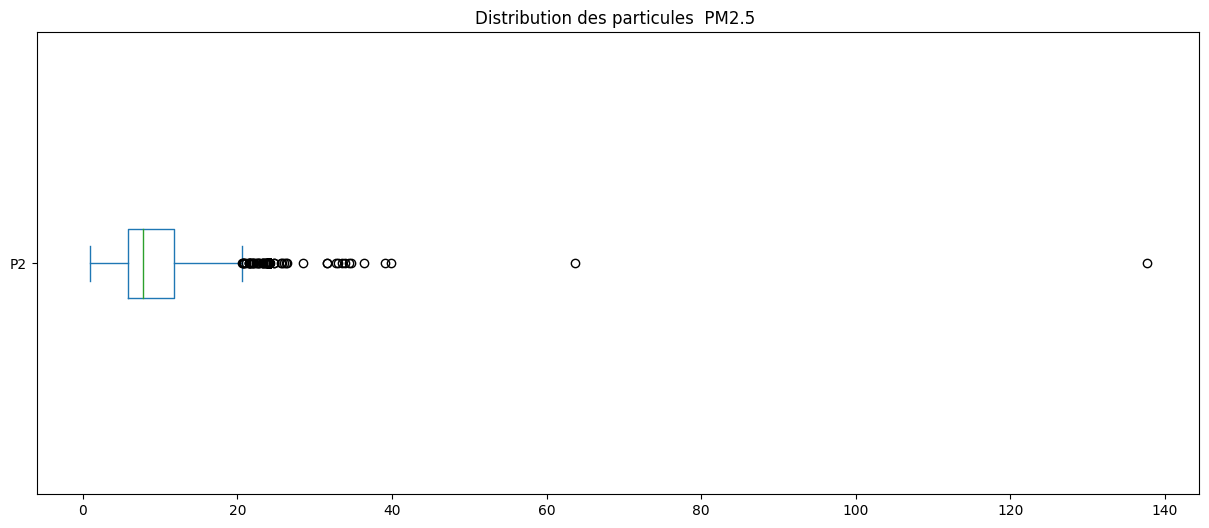

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))
test["P2"].plot(kind="box", vert=False, title="Distribution des particules  PM2.5 ", ax=ax);
 

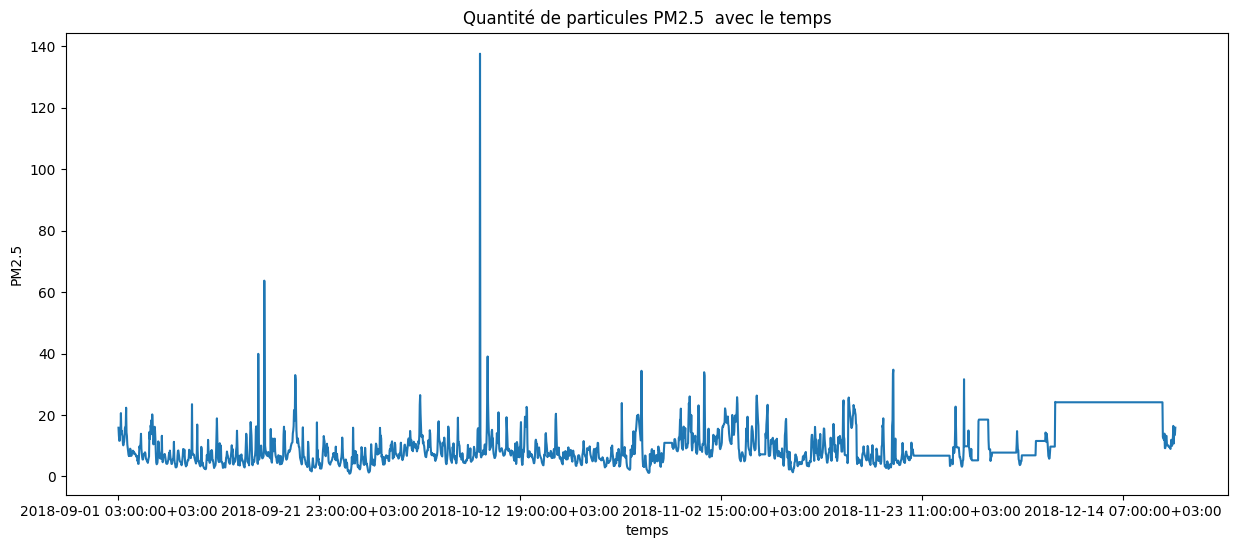

In [45]:
fig, ax = plt.subplots(figsize=(15, 6))
test["P2"].plot(xlabel ="temps", ylabel="PM2.5", title="Quantité de particules PM2.5  avec le temps", ax=ax);